# [オンライン開催]PyTorchで学ぶ深層学習入門第2回


## Section1. 活性化関数(Activation Functions)について
活性化関数について基本を学びつつ、ニューラルネットワークの最適化に関連する属性情報への関わりを見ます。  
活性化関数は、ニューラルネットワークに対して非線形性を付与するため、深層学習モデルを構築するにあたり基本かつ重要なものになります。文献によって多種多様な活性化関数があります。今日の勉強会の目的は、適切な活性化関数を選択することの重要性 (およびその方法) と、そうしないとどのような問題が発生するかについて学ぶことです。

まずは各種標準ライブラリや必要なライブラリをインポートしていきましょう。

In [ ]:
## 標準となるライブラリのインポート
import os
import json
import math
import numpy as np 

In [ ]:
## 可視化するためのライブラリのインポート
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

In [ ]:
## プロセス実行の進捗確認ツールのインポート
from tqdm.notebook import tqdm

In [ ]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

すべてのライブラリ (ここでは numpy と torch) にシード(乱数)を設定する関数を定義します。  
これによって、これから見ていく内容を再現可能にすることができます。ただし、CPU とは対照的に、異なるGPUアーキテクチャで同じシードを使用しても異なる結果になる可能性があることに注意してください。  

ここにあるすべてのモデルは、都度Google Colab上でGPUを選択して学習させたものになります。

さらに、次のセルは、DATASET_PATH と CHECKPOINT_PATH の 2 つのパスを定義します。データセット パスは、ノートブックで使用されるデータセットをダウンロードするディレクトリです。重複したダウンロードを防ぐために、PyTorch からのすべてのデータセットを 1 つの結合されたディレクトリに保存することをお勧めします。チェックポイント パスは、トレーニング済みのモデルの重みと追加のファイルを保存するディレクトリです。必要なファイルが自動的にダウンロードされます。 Google Colab を使用している場合は、現在のディレクトリから開始するようにディレクトリを変更することをお勧めします (つまり、データセットとチェックポイント パスの両方で ../ を削除します)。

In [ ]:
# データセットのダウンロード/ダウンロードされるフォルダへのパス (例: MNIST)
DATASET_PATH = "../data"
# 事前トレーニング済みモデルが保存されるフォルダへのパス
CHECKPOINT_PATH = "../saved_models/sample"

Using device cuda:0


In [ ]:
# シードを設定する関数
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [ ]:
# GPUでの一部処理については、効率を高めるために、確率論的な実装がされているので
# 再現性を担保するために、すべての操作が GPU (使用されている場合) で実行されているか確認します
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# ノートブック全体で使用されるデバイスを取得
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

次のセルは、このノートブックで使用するすべての事前トレーニング済みモデルをダウンロードします。ファイルは、特に ReadTheDocs でドキュメントを作成するために、ノートブック リポジトリのサイズを縮小するために別のリポジトリに保存されます。以下のダウンロードに失敗した場合は、Google ドライブ フォルダからモデルをダウンロードできます。

In [ ]:
import urllib.request
from urllib.error import HTTPError
# 訓練済みのモデル
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# ファイルのダウンロード
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar", 
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]

In [ ]:
# パスをもとにディレクトリを作成
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [ ]:
# 必要なファイルがダンロードされているかどうか確認
# ファイルがない場合、ダウンロード
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
class ActivationFunction(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

### Section1-1. 代表的な活性化関数

最初のステップとして、いくつかの一般的な活性化関数を自分で実装します。  
もちろん、それらのほとんどは `torch.nn` パッケージにもあります (概要についてはドキュメントを参照してください)が、理解と洞察を深めるために、独自の関数をここに記述します。

後半でさまざまな活性化関数を簡単に比較するため、  
活性化関数すべてのモジュールを継承するクラスを定義視します。

In [ ]:
# シグモイド関数
class Sigmoid(ActivationFunction):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

In [ ]:
# tanh関数
class Tanh(ActivationFunction):
    
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

すべての活性化関数は `nn.Module` になるため、実際にはこれらを呼び出してニューラルネットワークに埋め込むことができます。 `config` ディクショナリを使用して、一部の活性化関数に対して調整可能なパラメーターを保存します。

次に、さまざまなタスクで今でも一般的に使用されている、基本となる２つの活性化関数、`sigmoid` と `tanh` を実装しています。シグモイド関数と tanh関数による活性化については、PyTorch 関数 (`torch.sigmoid`、`torch.tanh`) またはモジュール (`nn.Sigmoid`、`nn.Tanh`) として定義されています。ここでは、それらを手動で実装します。
  
より深いネットワークのトレーニングを可能にしたもう1つの活性化関数は、Rectified Linear Unit (ReLU)  です。  
線形関数である、という単純さにもかかわらず、ReLU にはシグモイドや tanh と比較して大きな利点があります。それは、大きな範囲の値に対する強力で安定した勾配です。この考えに基づいて、ReLU には多くのバリエーションが提案されていますが、その中で LeakyReLU、ELU、Swish の 3つを実装します。  
  
`LeakyReLU` は、負の部分のゼロ設定を小さな勾配に置き換えて、入力のこの部分にも勾配が流れるようにします。
  
同様に、`ELU` は負の部分を指数関数的減衰に置き換えます。   
  
最近提案された活性化関数は `Swish`です。
これは、実際には「最適な」活性化関数を見つけることを目的とした結果、提案された活性化関数になります。

他の活性化関数と比較して、Swish は滑らかで単調ではありません (つまり、勾配に符号の変化が含まれます)。

これは、特に深いネットワークの場合、標準の ReLUのように不活性化したニューロンを防ぐことが示されています。興味がある場合は、Swish の利点に関するより詳細な説明が [Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017)](https://arxiv.org/abs/1710.05941) にあります。

以下の 4 つの活性化関数を実装しましょう。

In [ ]:
# ReLU関数
class ReLU(ActivationFunction):
    
    def forward(self, x):
        return x * (x > 0).float()

In [ ]:
# LeakyReLU関数
class LeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

In [ ]:
# ELU関数
class ELU(ActivationFunction):
    
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

In [ ]:
# Swish関数
class Swish(ActivationFunction):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

上記、６つの関数を定義したので、それらを辞書として呼び出せるようにします

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Section1-2. 活性化関数の可視化

各活性化関数が実際に何をするかを理解するために、以下でそれらを視覚化します。  
実際の関数を見た後に、関数の勾配がどのようになっているか視覚的に理解しましょう。これは、ニューラルネットワークを最適化するために不可欠です。 `PyTorch` を使用すると、`backward` 関数を呼び出すだけで勾配を計算できます。

In [ ]:
def get_grads(act_fn, x):
    """
    指定された位置で活性化関数の勾配を計算
    
    Inputs:
        act_fn - フォワード パスが実装されたクラス「ActivationFunction」のオブジェクト。x - 1D 入力テンソル.
    Output:
        x での act_fn の勾配を含む x と同じサイズのテンソル
    """
    x = x.clone().requires_grad_() # 勾配を保存したいテンソルとして入力を記録
    out = act_fn(x)
    out.sum().backward() # 合計すると、x の各要素に等しい勾配が得られる
    return x.grad # x.gradに格納されている x の勾配の取得

これで、勾配を含むすべての活性化関数を視覚化できます。

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # 活性化関数の実行
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # cpuで、x,y を可視化
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## 結果をプロットする
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

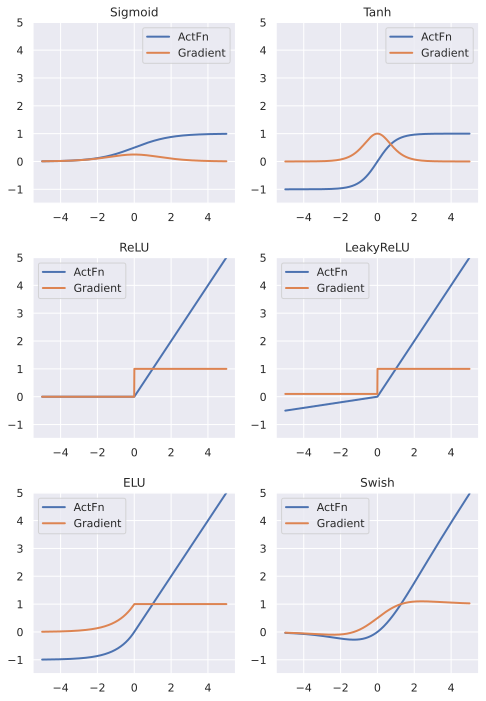

In [ ]:
# 各活性化関数の可視化
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## プロット
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## Section2. 活性化関数の効果について
関数を実装し、その効果・影響について見てみましょう。  
ここでは、前回紹介したFashionMNIST でトレーニングされた単純なニューラルネットワークを使用して行い、パフォーマンスや勾配の流れなど、モデルのさまざまな側面を調べます。

### Section2-1. 設定
まず、ニューラルネットワークを設定しましょう。選択されたネットワークは、画像を 1D テンソルとして表示し、一連の線形層と指定された活性化関数を介して画像を出力します

In [ ]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - ネットワークで非線形性として使用される活性化関数のオブジェクト
            input_size - 入力される画像のピクセルサイズ
            num_classes - 分類する数
            hidden_sizes - 隠れ層のサイズを指定する整数のリスト
        """
        super().__init__()
        
        # 中間層の設定
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential モジュールのリストを 1つのモジュールに集約し、それらを順番に適用
        
        # モデルの保存と読み込みのために、すべてのハイパーパラメータを保存
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # 画像をベクトルに変換する
        out = self.layers(x)
        return out

モデルの読み込みと保存のための関数も追加します。ハイパーパラメータは構成ファイル (単純な json ファイル) に保存されます。

In [ ]:
def _get_config_file(model_path, model_name):
    # ハイパーパラメータの詳細を保存するファイル名
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # ニューラルネットワークのパラメータを格納するファイル
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - モデルを格納するディレクトリパス
        model_name - str型で表現した、モデル名
        net - (オプション) 指定された場合、状態辞書がこのモデルに読み込まれる。それ以外の場合は、新しいモデルが作成する
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    """
    モデルが与えられたら、state_dict とハイパーパラメータを保存
    
    Inputs:
        model - パラメータを保存するネットワーク オブジェクト
        model_path - モデルのディレクトリのパス
        model_name - モデル名
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

また、トレーニングに使用するデータセット、つまり FashionMNIST も準備します。 FashionMNIST は MNIST のより複雑なバージョンであり、数字の代わりに衣服の白黒画像が含まれています。ズボン、コート、靴、バッグなどの 10 のクラスがあります。このデータセットをロードするために、さらに別の PyTorch パッケージ、すなわち `torchvision`を利用します。 `torchvision` パッケージは、一般的なデータセット、モデル アーキテクチャ、およびコンピュータビジョンの一般的な画像変換で構成されています。データセットの処理を簡素化するために、このコースの多くのノートブックでパッケージを使用します。

以下のデータセットを読み込み、いくつかの画像を視覚化してデータの印象をつかみましょう。

In [ ]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 各画像に適用される変換 => 最初にテンソルを作成し、次に -1 から 1 の範囲で正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# トレーニング データセットを読み込み。トレーニングと検証の部分に分割する
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータの読み込み
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# さまざまな目的に使用できる一連のデータ ローダーを定義
# 実際にモデルをトレーニングするには、さまざまなデータローダーを利用します
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



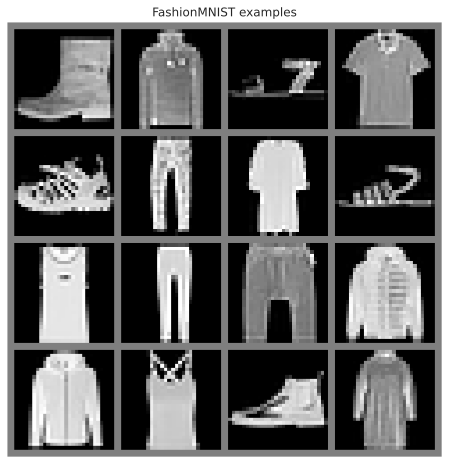

In [ ]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# 可視化
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Section2-2. 初期化後の勾配の流れの可視化
前述のように、活性化関数の重要な側面の 1 つは、ネットワークを介して勾配を伝播する方法です。 50層を超える非常に深いニューラルネットワークがあるとします。入力層、つまり一番最初の層の勾配は、活性化関数の 50倍を超えていますが、それでも適切なサイズにする必要があります。活性化関数による勾配が (予想どおり) 1 よりかなり小さい場合、勾配は入力層に到達するまで消えます。活性化関数による勾配が 1 より大きい場合、勾配は指数関数的に増加し、爆発する可能性があります。

すべての活性化関数が勾配にどのように影響するかを把握するために、新たに初期化されたネットワークを見て、256 個の画像のバッチの各パラメーターの勾配を測定できます。

In [ ]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # ネットワークを介して 1 つのバッチを渡し、重みの勾配を計算
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # 可視化する際に、重みパラメータに制限して処理を軽量化する
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    ## 可視化
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close() 

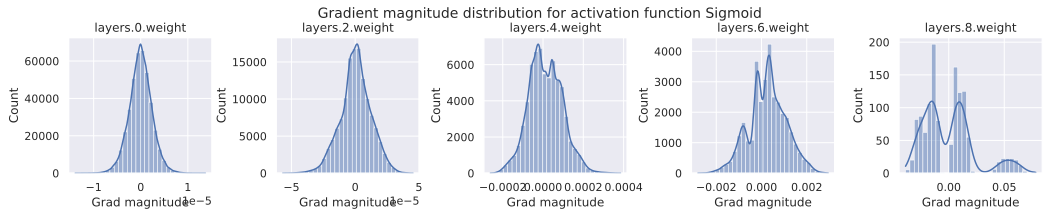

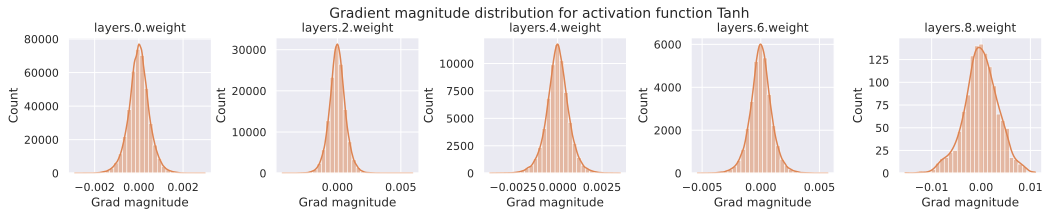

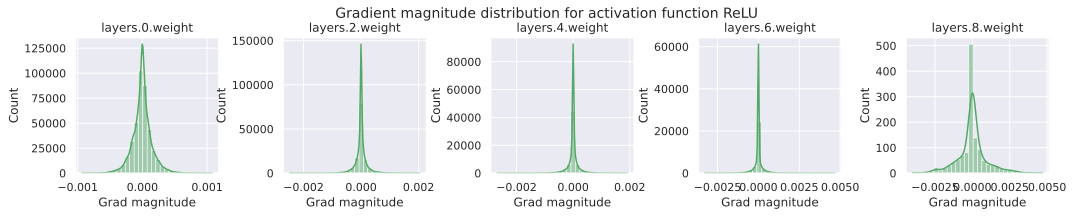

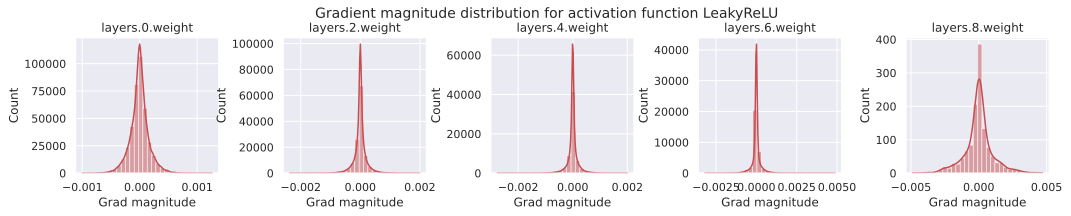

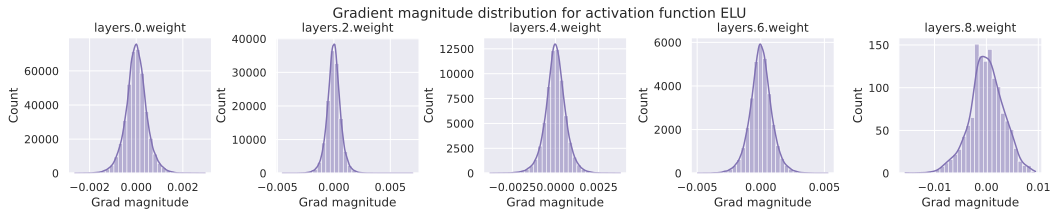

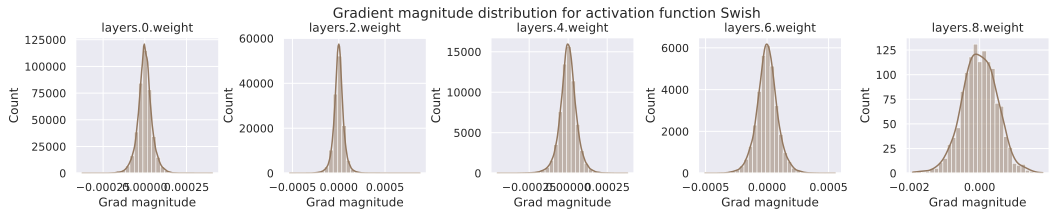

In [ ]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

シグモイド活性化関数は、明らかに望ましくない動作を示します。  
  
出力層の勾配は最大 0.1 と非常に大きく、入力層の勾配ノルムはすべての活性化関数で 1e-5 しかありません。  
  
これは、最大勾配が 1/4 と小さいためであり、この設定ではすべてのレイヤーで適切な学習率を見つけることはできません。他のすべての活性化関数は、すべてのレイヤーで同様の勾配ノルムを持つことを示しています。興味深いことに、ReLU 活性化には 0 付近でスパイクがあり、これは左側のゼロ部分と不活性なニューロンによって引き起こされます (これについては後で詳しく見ていきます)。

また、重みパラメータの初期化が重要になる場合があることに注意してください。  
デフォルトでは、PyTorch は ReLU アクティベーション用に最適化された線形レイヤーに `Kaiming` 初期化を使用します。これらについては次回説明します。

### Section2-3. モデルの学習
次に、FashionMNIST でさまざまな活性化関数を使用してモデルをトレーニングし、得られた性能を比較します。全体として、最終的な目標は、選択したデータセットで可能な限り最高のパフォーマンスを達成することです。したがって、次のセルに、エポックごとの検証と最適なモデルの最終テストを含むトレーニングループを記述します。

In [ ]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - 元となるニューラルネットのアーキテクチャ
        model_name - モデル名
        max_epochs - エポックの最大数
        patience - 検証セットのパフォーマンスが #patience エポックで改善されなかった場合、早期にトレーニングを停止
        batch_size - バッチサイズ
        overwrite - チェックポイントが既に存在する場合の処理​​方法を決定 Trueの場合、上書。それ以外の場合は、トレーニングをスキップ
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # オプティマイザー、ロス、データローダーの定義
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # 学習 #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # zero-grad は　loss.backward()　の前の任意の場所に格納
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # 学習の経過を取得
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # 検証 #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # 精度を取得
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

活性化関数ごとに 1 つのモデルをトレーニングします。  
このノートブックを CPU で実行している場合は、事前トレーニング済みのモデルを使用して時間を節約することをお勧めします。

In [ ]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.59% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.92% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.27% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.73% ==============



驚くことではありませんが、シグモイド活性化関数を使用するモデルは失敗することが示され、ランダム パフォーマンスが向上しません (10 クラス => ランダム チャンスの 1/10)。

他のすべての活性化関数は、同様のパフォーマンスを獲得します。より正確な結論を得るには、複数のシードについてモデルをトレーニングし、平均を確認する必要があります。ただし、「最適な」アクティベーション関数は、他の多くの要因 (隠れたサイズ、レイヤーの数、レイヤーの種類、タスク、データセット、オプティマイザー、学習率など) にも依存するため、完全なグリッド検索は、場合。文献では、深層ネットワークでうまく機能することが示されている活性化関数は、ここで実験するすべてのタイプの ReLU 関数であり、特定のネットワーク内の特定の活性化関数に対してわずかな利益しかありません。

### Section2-4. 活性化分布の可視化
モデルをトレーニングした後、モデル内にある実際の活性化を確認できます。たとえば、ReLU でゼロに設定されているニューロンはいくつありますか? Tanh で最も価値のある場所はどこですか?これらの質問に答えるために、訓練されたモデルを取り、それを画像のバッチに適用し、ネットワーク内の活性化のヒストグラムをプロットする単純な関数を書くことができます:

In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # 
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()
    
    ## 可視化
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

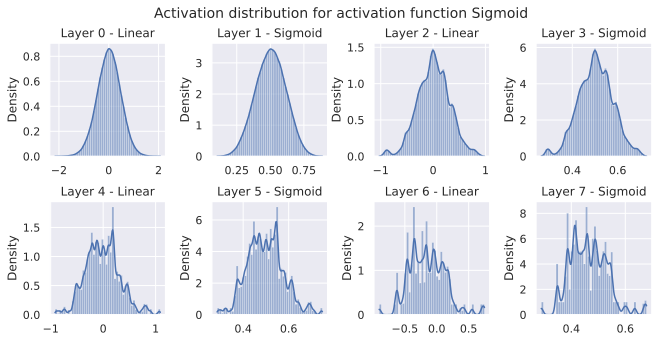

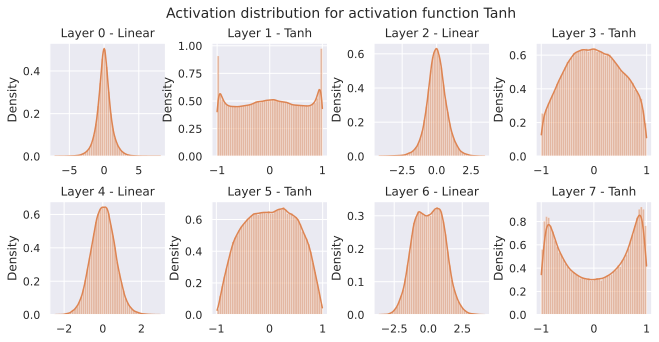

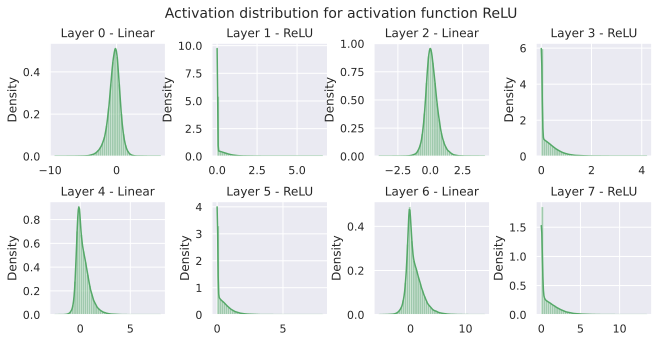

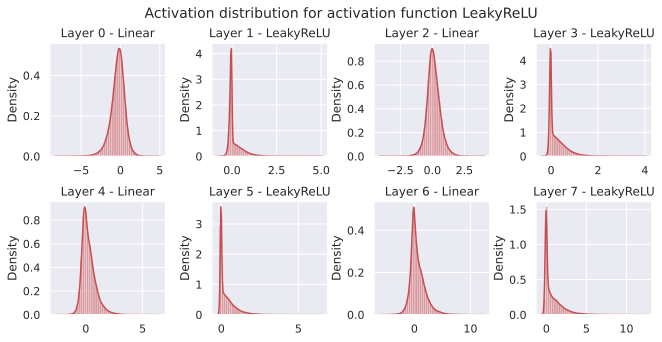

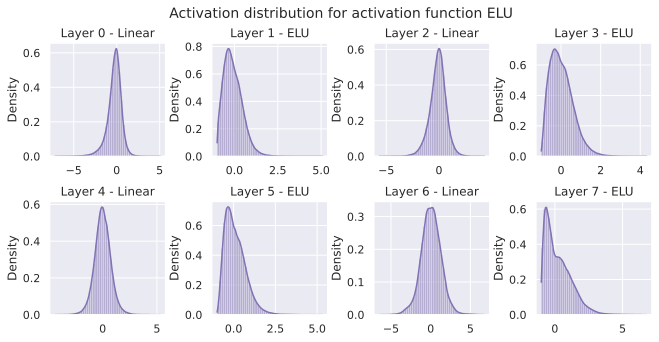

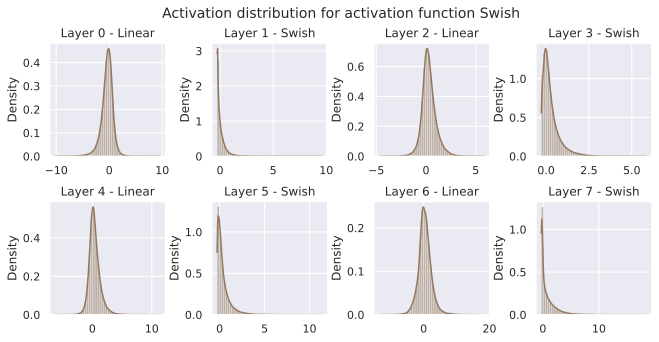

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

シグモイド 活性化を含むモデルは適切にトレーニングできなかったため、情報量が少なく、すべてが 0.5 付近に集まっています (入力 0 での活性化)。

tanh は、より多様な動作を示します。入力層では、勾配が 0 に近い -1 と 1 に近い大量のニューロンが発生しますが、2 つの連続する層の活性化は 0 に近づきます。これはおそらく、入力レイヤーが入力画像内の特定の機能を探し、連続するレイヤーがそれらを結合するためです。分類レイヤーはこれらの値の加重平均と見なすことができるため、最後のレイヤーの活性化は再び極値に偏っています (勾配が活性化をこれらの極値にプッシュします)。

当初の予想どおり、ReLU は 0 に強いピークを持っています。負の値に勾配がないことの効果は、ネットワークが線形層の後にガウスのような分布を持たず、正の値に向かって長いテールを持たないことです。 LeakyReLU は非常によく似た動作を示しますが、ELU はよりガウスに近い分布に従います。 Swish はその中間にあるように見えますが、Swish は他の活性化関数よりもかなり高い値 (最大 20) を使用することに注意してください。

単純なネットワークでは同様のパフォーマンスが得られますが、すべての活性化関数はわずかに異なる動作を示すため、「最適な」活性化関数の選択は実際には多くの要因に依存し、すべての可能なネットワークで同じではないことが明らかになります。

## Section3. ReLUにおいて不活性なニューロンを可視化してみる
ReLU 活性化の既知の欠点の 1 つは、「死んだニューロン」、つまりトレーニング入力に対して勾配のないニューロンの発生です。死んだニューロンの問題は、レイヤーに勾配が提供されていないため、前のレイヤーでこのニューロンのパラメーターをトレーニングしてゼロ以外の出力値を取得できないことです。死んだニューロンが発生するには、ReLU の前の線形層の特定のニューロンの出力値が、すべての入力画像に対して負でなければなりません。ニューラル ネットワーク内に多数のニューロンがあることを考えると、これが発生する可能性は低くありません。

これがどの程度の問題であるかをよりよく理解するために、また注意が必要な場合は、さまざまなネットワークにある死んだニューロンの数を測定します。このために、トレーニング セット全体でネットワークを実行し、ニューロンがすべてのデータ ポイントに対して正確に 0 であるかどうかを記録する関数を実装します。

In [ ]:
def measure_number_dead_neurons(net):

    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] 

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): 
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

まず、訓練されていないネットワークの死んだニューロンの数を測定できます。

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


死んでいるニューロンはごくわずかですが、層の深さとともに増加することがわかります。ただし、これは、前の層の重みの更新により後の層への入力が変更されるため、死んだニューロンの数が少ないため問題ではありません。したがって、後の層の死んだニューロンは、潜在的に「生きている」/再びアクティブになる可能性があります。

訓練されたネットワーク (同じ初期化) では、これはどのように見えるでしょうか?

In [ ]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 3]
In percentage: 0.00%, 0.00%, 0.00%, 2.34%


実際、死んだニューロンの数は後の層で減少しました。ただし、死んだニューロンは入力層で特に問題になることに注意してください。入力はエポック間で変化しない (トレーニング セットはそのまま維持される) ため、ネットワークをトレーニングしてもこれらのニューロンをアクティブに戻すことはできません。それでも、入力データは通常、死んだニューロンのリスクを減らすのに十分なほど高い標準偏差を持っています。

最後に、層の深さが増すにつれて死んだニューロンの数がどのように動作するかを確認します。たとえば、次の 10 層ニューラル ネットワークを考えてみましょう。

In [ ]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


死んだニューロンの数は以前よりも大幅に多くなり、特に最初の反復で勾配の流れが損なわれます。たとえば、最後の前層のニューロンの 56% 以上が死んでおり、かなりのボトルネックが生じています。したがって、非常に深いネットワークには Swish などの他の非線形性を使用することをお勧めします。

このノートブックでは、ニューラル ネットワークの 6 つの活性化関数 (sigmoid、tanh、ReLU、LeakyReLU、ELU、および Swish) のセットを確認し、それらが層全体の勾配分布にどのように影響するかについて説明しました。シグモイドは、それが提供する最高勾配が 0.25 であるため、ディープ ニューラル ネットワークに失敗する傾向があり、初期層で勾配が消失します。すべての ReLU ベースの活性化関数はうまく機能することが示されており、元の ReLU 以外に、死んだニューロンの問題はありません。独自のニューラル ネットワークを実装する場合は、ReLU ベースのネットワークから始めて、ネットワークのプロパティに基づいて特定の活性化関数を選択することをお勧めします。